In [11]:
cd("/Users/federicoclaudi/Documents/Github/LocomotionControl/analysis/behavior")
import Pkg; 
Pkg.activate(".")

using Plots, CSV, Term
import Term: install_term_logger
import MyterialColors: salmon, green_dark, blue_grey_darker
using Statistics
import DataFrames: DataFrame
using StatsBase
using Glob, NaturalSort, Colors

using jcontrol
using jcontrol.visuals
import jcontrol.visuals: arena
import jcontrol.comparisons: ComparisonPoints
import jcontrol.io: PATHS

install_term_logger();

  Activating project at `~/Documents/Github/LocomotionControl/analysis/behavior`


In [12]:
# load trials
trials = load_cached_trials(; keep_n = nothing);
@info "Loaded $(length(trials)) trials"

S = getfield.(trials, :s)
speed = map(t -> sqrt.(t.u .^ 2 .+ t.v .^ 2), trials)
U = getfield.(trials, :u)
Ω = getfield.(trials, :ω);

# load comparison points
cpoints = ComparisonPoints(FULLTRACK; δs=10, trials=trials, s₀=1.0, s₁=250.0);

InterruptException: Error trying to display an error.

In [13]:
# create trials speed and angular velocity heatmaps
speed = zeros(250, 100)
ω = zeros(250, 30)

for (n, cp) in enumerate(cpoints.points[3:end-1])
    sp = fit(Histogram, cp.kinematics.u.values, 1:101)
    speed[n, :] .= sp.weights


    angvel = fit(Histogram, cp.kinematics.ω.values, -15:15)
    ω[n, :] .= angvel.weights
end

@Info (Main):  Loaded 555 trials
  ╰────────────────────────────────────────────────
                      Fri, 15 Apr 2022 11:45:20


In [14]:
# load MTM global solution
globalsolution = DataFrame(CSV.File(joinpath(PATHS["horizons_sims_cache"], "global_solution.csv")))
globalsolution = Solution(globalsolution);
gs_speed = sqrt.(globalsolution.u .^ 2 .+ globalsolution.v .^ 2);

In [15]:
# load individual solutions
files = sort(glob("multiple_horizons_mtm_horizon_length*.csv", PATHS["horizons_sims_cache"]), lt=natural)
solutions = map(file-> Solution(DataFrame(CSV.File(file))), files)
names = map(file -> split(file, "_")[end][1:end-4], files);

In [16]:
calcspeed(solution, idx) = sqrt.(solution.u[idx] .^ 2 .+ solution.v[idx] .^ 2)


# get solution kinematics at control points
struct Kinematics
    s::Vector{Number}
    speed::Vector{Number}
    ω::Vector{Number}
    planning_window::Float64
end

function Kinematics(solution, points, planning_window)
    svals, s, ω = [], [], []
    for p in points
        idx = findfirst(solution.s .>= p.s)
        isnothing(idx) && println("Solution $planning_window stops before $(p.s)")
        isnothing(idx) && return nothing

        push!(s, calcspeed(solution, idx))
        push!(ω, solution.ω[idx])
        push!(svals, p.s)
    end

    planning_window = planning_window isa AbstractString ? parse(Float64, planning_window) : planning_window
    return Kinematics(svals, s, ω, planning_window)
end

# get kinematics MSE wrt to global solution
struct MSE
    speed::Float64
    ω::Float64
    planning_window::Float64
    s::Float64
end

function MSE(globalsolution::Kinematics, solution::Kinematics)
    @assert length(solution.s) == length(globalsolution.s)
    return MSE(
        mean((globalsolution.speed .- solution.speed).^2),
        mean((globalsolution.ω .- solution.ω).^2),
        solution.planning_window,
        0.0
    )
end


pts = cpoints.points[2:end-1]

gs_kinematics = Kinematics(globalsolution, pts, 100.1);
solutions_kinematics = filter(k -> !isnothing(k), map(s -> Kinematics(s[1], pts, s[2]), zip(solutions, names)));
@info "Got $(length(solutions_kinematics)) solution kinematics  (out of $(length(files)) files)"

MSEs = map(kin -> MSE(gs_kinematics, kin), solutions_kinematics);

colors = range(HSL(326, .9, .68), stop=HSL(212, .9, .6), length=max(2, length(MSEs)))
alphas = range(.9, .6, length=max(5, length(MSEs)));


Solution 0.12 stops before 31.0
Solution 0.14 stops before 21.0
Solution 0.16 stops before 21.0
Solution 0.18 stops before 21.0
Solution 0.30 stops before 231.0
Solution 0.36 stops before 1.0
Solution 0.38 stops before 1.0
@Info (Main):  Got 7 solution kinematics  (out of 14 files)
  ╰────────────────────────────────────────────────
                      Fri, 15 Apr 2022 11:45:24


### Make plot

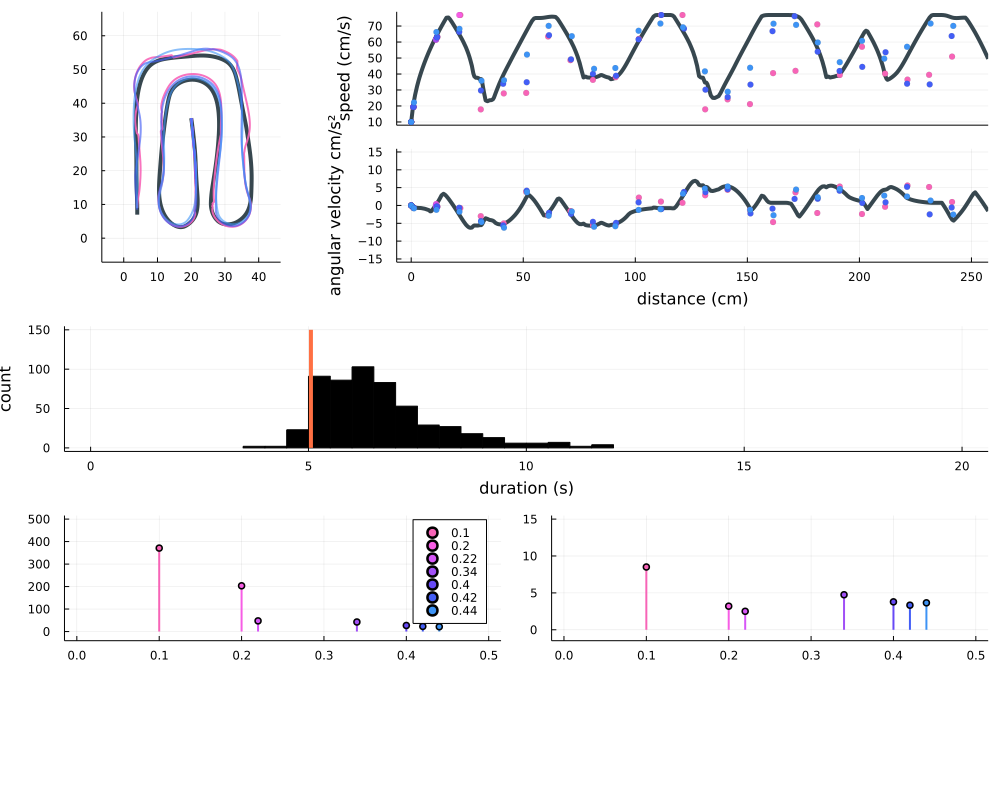

In [17]:
layout = @layout [
    a{1.0h} grid(2, 1){.7w, 1.0h} 
    c{.2h}
    d{.5h} e{.5h}
]

fig = plot(; layout=layout, size=(1000, 800))


plot!(
    globalsolution.x, globalsolution.y,
    lw=4, color=blue_grey_darker, label=nothing, subplot=1,
    aspect_ratio=:equal, xlim=[-5, 45], ylim=[-5, 65]
)

# plot global solution kinematics at checkpoints
# for cp in cpoints.points[2:end-1]
#     idx = findfirst(globalsolution.s .>= cp.s)
#     scatter!(
#         [globalsolution.s[idx]], [√(globalsolution.u[idx]^2 + globalsolution.v[idx]^2)],
#         color=blue_grey_darker, label=nothing, subplot=2, ms=8, msw=0
#     )

#     scatter!(
#         [globalsolution.s[idx]], [globalsolution.ω[idx]],
#         color=blue_grey_darker, label=nothing, subplot=3, ms=8, msw=0
#     )
# end

plot!(
    globalsolution.s, sqrt.(globalsolution.u .^ 2 .+ globalsolution.v .^ 2),
    lw=4, color=blue_grey_darker, label=nothing, subplot=2,
)
plot!(
    globalsolution.s, globalsolution.ω,
    lw=4, color=blue_grey_darker, label=nothing, subplot=3,
)


# plot trials durations histogram
histogram!(
    getfield.(trials, :duration), 
    bins=25, 
    color="black", 
    subplot=4,
    colorbar=false, label=nothing,
)
plot!(
    [globalsolution.t[end], globalsolution.t[end]], [0, 150], subplot=4,
    lw=4, color=salmon, alpha=1.0, label=nothing
)

# plot individual solutions 
for (n, (solution, color, alpha)) in enumerate(zip(solutions, colors, alphas))
    # plot XY trajectory
    plot!(
        solution.x, solution.y, color=color, subplot=1, label=nothing, lw=2, alpha=alpha
    )


    # plot kinematics
    for cp in cpoints.points[2:end-1]
        idx = findfirst(solution.s .>= cp.s)
        isnothing(idx) && continue
        scatter!(
            [solution.s[idx]], [√(solution.u[idx]^2 + solution.v[idx]^2)],
            color=color, label=nothing, subplot=2, ms=3.4, msw=0
        )
    
        scatter!(
            [solution.s[idx]], [solution.ω[idx]],
            color=color, label=nothing, subplot=3, ms=3.4, msw=0
        )
    end

#     plot!(
#         solution.s, sqrt.(solution.u .^ 2 .+ solution.v .^ 2), color=color, subplot=2, label=nothing, lw=3, alpha=alpha
#     )
#     plot!(
#         solution.s, solution.ω, color=color, subplot=3, label=nothing, lw=3, alpha=alpha
#     )
#     plot!(
#         [solution.t[end], solution.t[end]], [0, 50 + 10n], subplot=4,
#         lw=2, color=color, alpha=1, label=nothing
#     )
end


# plot MSEs
for i in 1:length(MSEs)
    ms = MSEs[i]
    plot!(
        [ms.planning_window, ms.planning_window],
        [0, ms.speed],
        color=colors[i], lw=2, subplot=5, label=nothing
    )
    scatter!(
        [ms.planning_window],
        [ms.speed],
        color=colors[i],  subplot=5, label=ms.planning_window,
    )

    plot!(
        [ms.planning_window, ms.planning_window],
        [0, ms.ω],
        color=colors[i], lw=2, subplot=6, label=nothing
    )
    scatter!(
        [ms.planning_window],
        [ms.ω],
        color=colors[i],  subplot=6, label=nothing,
    )
end
# scatter!(
#     getfield.(MSEs, :planning_window),
#     getfield.(MSEs, :speed),
#     subplot=5, label=nothing
# )

# set plot properties
plot!(; subplot=2, xlim=[1, 250], xticks=[], ylabel="speed (cm/s)")
plot!(; subplot=3, ylim=[-15, 15], xlim=[1, 250], xlabel="distance (cm)", ylabel="angular velocity cm/s²")
plot!(; subplot=4, xlim=[0, 20], xlabel="duration (s)", ylabel="count")
plot!(; subplot=5, ylim=[-25, 500], xlim=[0, .5])
plot!(; subplot=6, ylim=[-1, 15], xlim=[0, .5])

display(fig)